In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
dataset = pd.read_csv('database/raw_master_combined_data.csv')
print(dataset.shape)
dataset.head()

(2188, 16)


,Day,T,TM,Tm,SLP,H,PP,VV,V,VM,VG,RA,SN,TS,FG,PM2.5
0,2013-01-01 00:00:00,8.9,15,5,-,93,0,0.5,4.8,11.1,-,NaN,NaN,NaN,o,284.795833
1,2013-01-02 00:00:00,9.2,-,4,-,97,0,0.5,9.4,16.5,-,NaN,NaN,NaN,o,239.695455
2,2013-01-03 00:00:00,6.6,10,3,-,99,0,0.6,8.1,13,-,NaN,NaN,NaN,o,182.187500
3,2013-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,197.635714
4,2013-01-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,NaN


### Converting the complete dataset vals str->float

In [3]:
def convert(x):
    try:
        return float(x)
    except:
        return np.nan
    
for f in dataset.columns:
    dataset[f] = dataset[f].apply(convert)

## Handling Null Values

#### Deleting all the samples with NaN value of Target Feature (PM2.5)

In [4]:
data = dataset.copy()

data.dropna(subset=['PM2.5'], inplace=True)

def find_na_percent(): return data.isnull().sum()/len(data)*100

percentages = find_na_percent()
percentages

Day      100.000000
T         49.006623
TM        49.101230
Tm        49.006623
SLP       99.763482
H         49.006623
PP        53.595080
VV        49.006623
V         49.006623
VM        49.053926
VG        85.998108
RA       100.000000
SN       100.000000
TS       100.000000
FG       100.000000
PM2.5      0.000000
dtype: float64

### Removing features having Nan Percentage greater that THRESHOLD

In [5]:
THRESHOLD = 60

useless_features = [f for f in percentages.index if percentages[f]>THRESHOLD] + ['Day'] # We don't need this feature

data = data.drop(columns=useless_features)
data.index = range(len(data))
data.head()

,T,TM,Tm,H,PP,VV,V,VM,PM2.5
0,8.9,15.0,5.0,93.0,0.0,0.5,4.8,11.1,284.795833
1,9.2,NaN,4.0,97.0,0.0,0.5,9.4,16.5,239.695455
2,6.6,10.0,3.0,99.0,0.0,0.6,8.1,13.0,182.187500
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.635714
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,297.100000


### Analyzing the datapoints of the features

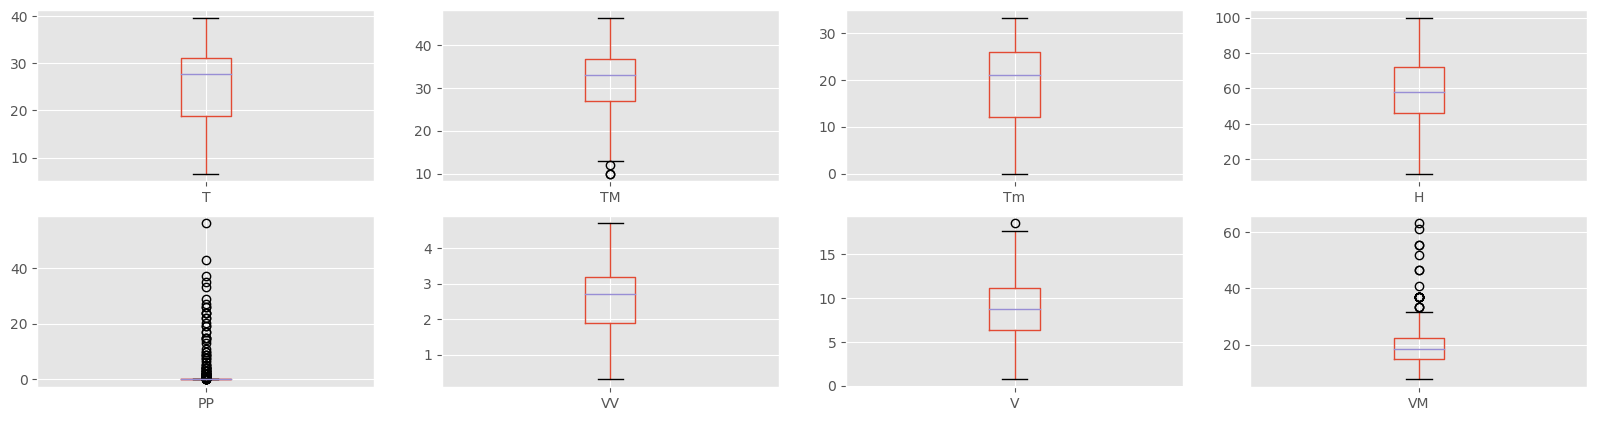

In [6]:
plt.figure(figsize=(20, 5), dpi=100)
for idx, f in enumerate(data.columns[:-1]):
    
    plt.subplot(2, 4, idx+1)
    data[f].plot(kind='box')
    plt.grid(1)

As we can see:
* PP and VM has a lot of outliers

Thus, we'll replace the NaN values of PP and VM with **MEDIAN** and others with **MEAN**

### Replacing NaN Values

In [7]:
for f in data.columns:
    if f in ['PP', 'VM']:
        data[f] = np.where(data[f].isnull(), data[f].median(), data[f])   # data.fillna(data[x].mean(), inplace=True))
    else:
        data[f] = np.where(data[f].isnull(), data[f].mean(), data[f])


In [8]:
find_na_percent()

T        0.0
TM       0.0
Tm       0.0
H        0.0
PP       0.0
VV       0.0
V        0.0
VM       0.0
PM2.5    0.0
dtype: float64

In [9]:
isNull = pd.DataFrame()

for f in data.columns:
    isNull[f'{f}_isNull'] = np.where(data[f].isnull(), False, True)

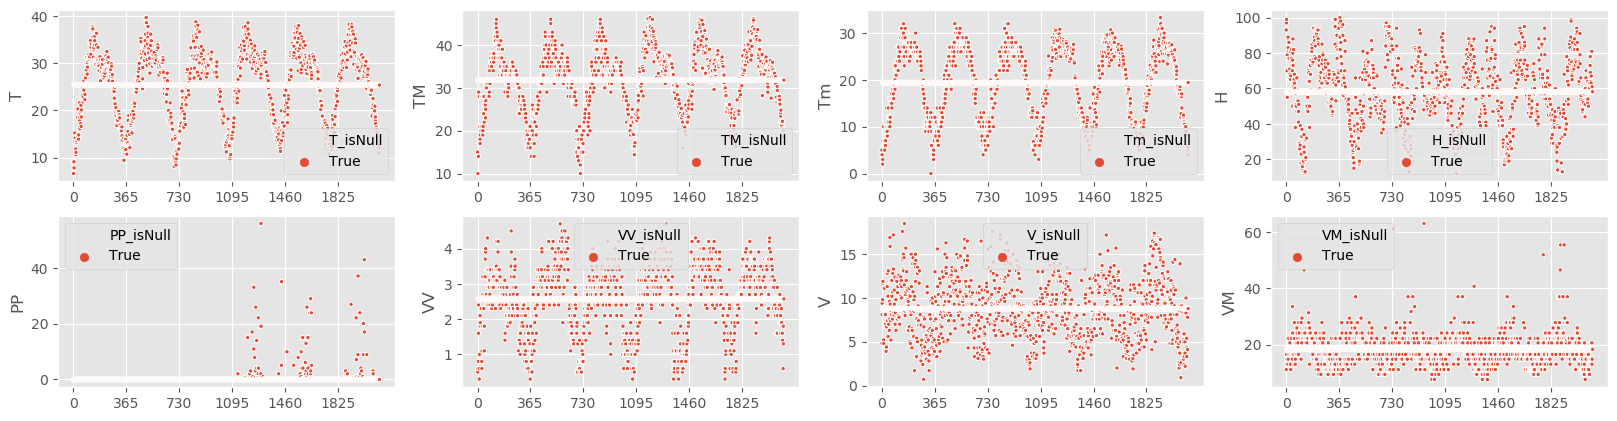

In [10]:
plt.figure(figsize=(20, 5), dpi=100)
for idx, f in enumerate(data.columns[:-1]):
    
    plt.subplot(2, 4, idx+1)
    sns.scatterplot(x=data.index, y=f, data=pd.concat([data, isNull], axis=1), hue=f'{f}_isNull', s=10)
    plt.xticks(range(0, len(data), 365)) # Make a YEAR LONG Window of X-axis, so that it gets a little easier to interpret
    plt.grid(1)

# Feature Selection

We can see that, PP does not show a pattern, because, for the years 2013-15, PP hold almost 0 val, but after that it is occuring.

Let's try making a model without including and compare the results.

I WAS WRONG. THE R2 SCORE TOOK A MAJOR HIT AFTER DROPPING IT. BUT WHY?

Because, acc to the dataset source, 
* PP : Total rainfall and / or snowmelt (mm)

It can be concluded that AQI can highly depend on rainfall.

In [108]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts

FEATURES = data.drop(columns='PM2.5')
TARGET   = data['PM2.5']
NUMBER_OF_FEATURES_TO_SELECT = 5

# Applying the Feature Selection
rfe_selector = RFE(estimator=RandomForestRegressor(), n_features_to_select=NUMBER_OF_FEATURES_TO_SELECT, step=10, verbose=5)
rfe_selector.fit(FEATURES, TARGET)
rfe_support = rfe_selector.get_support()
rfe_feature = FEATURES.loc[:,rfe_support].columns.tolist()


print(str(len(rfe_feature)), 'selected features')
print('Selected Features :', rfe_feature)

Fitting estimator with 8 features.
5 selected features
Selected Features : ['T', 'Tm', 'H', 'VV', 'V']


# Normalizing and Splitting

In [98]:
# Creating a Pipeline for normalizing and Splitting the Data
def normalize_and_split(data, selected_features, target_feature, test_size=0.1):
    features = data.drop(columns=selected_features)
    target   = data[target_feature]

    scale = MinMaxScaler()
    features = pd.DataFrame(scale.fit_transform(features))
    
    X_train, X_test, y_train, y_test = tts(features, target, test_size=test_size)
    return X_train, X_test, y_train, y_test

In [109]:
X_train, X_test, y_train, y_test = normalize_and_split(data, rfe_feature, 'PM2.5')

# Training

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def info(**kwargs):
    for k, v in kwargs.items():
        print(f'{k} :', v)

In [101]:
predictions = {}

## Linear Regression

In [119]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

predictions['lr'] = lr_model.predict(X_test)
predictions['lr_train'] = lr_model.predict(X_train)

mse = mean_squared_error(y_test, predictions['lr'])
mae = mean_absolute_error(y_test, predictions['lr'])
r2  = r2_score(y_test, predictions['lr'])
r2_train  = r2_score(y_train, predictions['lr_train'])

info(mse=mse, mae=mae, r2=r2, r2_train=r2_train)

mse : 3.45427306228258e-27
mae : 3.4781402077124714e-14
r2 : 1.0
r2_train : 1.0


## Decision Tree

In [120]:
dt_model = DecisionTreeRegressor(max_depth=3)
dt_model.fit(X_train, y_train)

predictions['dt'] = dt_model.predict(X_test)
predictions['dt_train'] = dt_model.predict(X_train)

mse = mean_squared_error(y_test, predictions['dt'])
mae = mean_absolute_error(y_test, predictions['dt'])
r2  = r2_score(y_test, predictions['dt'])
r2_train  = r2_score(y_train, predictions['dt_train'])

info(mse=mse, mae=mae, r2=r2, r2_train=r2_train)

mse : 203.90050368074805
mae : 11.340487644240177
r2 : 0.9756362449839731
r2_train : 0.9737545548325324


## Random Forest

In [121]:
rf_model = RandomForestRegressor(max_depth=3)
rf_model.fit(X_train, y_train)

predictions['rf'] = rf_model.predict(X_test)
predictions['rf_train'] = rf_model.predict(X_train)

mse = mean_squared_error(y_test, predictions['rf'])
mae = mean_absolute_error(y_test, predictions['rf'])

r2  = r2_score(y_test, predictions['rf'])
r2_train  = r2_score(y_train, predictions['rf_train'])

info(mse=mse, mae=mae, r2=r2, r2_train=r2_train)

mse : 92.86625707322726
mae : 7.158504053485721
r2 : 0.988903554941041
r2_train : 0.987553404548585


## XGBoost

In [122]:
from xgboost import XGBRegressor

In [123]:
xgb_model = XGBRegressor(max_depth=1, num_workers=2)
xgb_model.fit(X_train, y_train)

predictions['xgb'] = xgb_model.predict(X_test)
predictions['xgb_train'] = xgb_model.predict(X_train)

mse = mean_squared_error(y_test, predictions['xgb'])
mae = mean_absolute_error(y_test, predictions['xgb'])

r2  = r2_score(y_test, predictions['xgb'])
r2_train  = r2_score(y_train, predictions['xgb_train'])


info(mse=mse, mae=mae, r2=r2, r2_train=r2_train)

mse : 42.41742751507735
mae : 4.745437479892208
r2 : 0.9949316073588248
r2_train : 0.9943676710365037


# Visualizing the Results

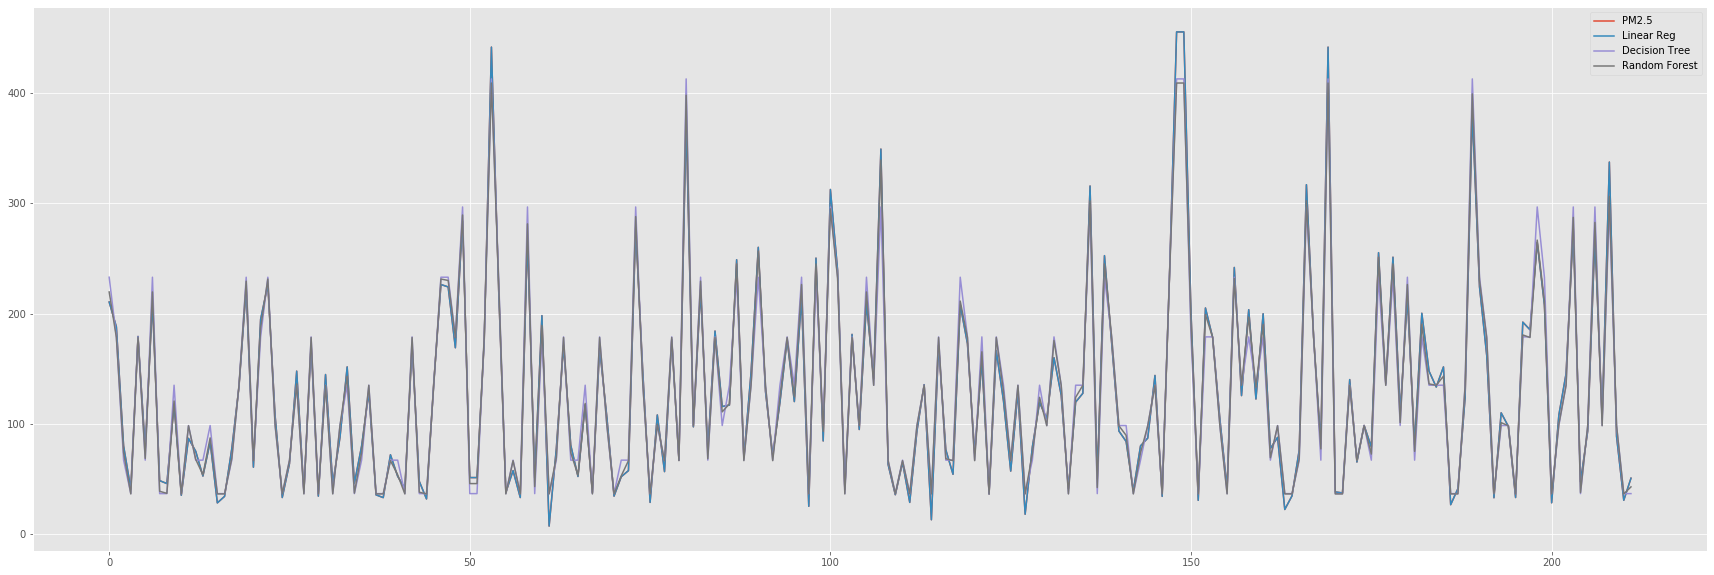

In [114]:
# plt.figure(figsize=(30, 10))

y_test.index=range(len(y_test))

pd.concat([y_test, 
           pd.DataFrame(predictions['lr'], columns=['Linear Reg']), 
           pd.DataFrame(predictions['dt'], columns=['Decision Tree']), 
           pd.DataFrame(predictions['rf'], columns=['Random Forest'])], 
          axis=1).plot(figsize=(30, 10))